# Machine Learning with Phenotypic Data

This notebook investigates the performance of machine learning models to recognize ADHD in subjects. 
The original dataset for this test consists of average signal intensities for regions of the brain as determined by the AAL atlas from the 7 training sites in the ADHD-200 Competition set. 
The dataset that will be used in this notebook has been adapted from the original to include only the regions that have the highest correlation to the target (diagnosis).

This notebook runs four tests to evaluate the accuracy of multiple classification models.
1. Multi-class diagnosis (uses all diagnosis types)
1. Multi-class diagnosis (uses all diagnosis types) with normalized features
2. Binary classification (if subject has ADHD or not)
2. Binary classification (if subject has ADHD or not) with normalized features

## Imports

These are the imports that are required for this notebook to run properly

- `os` to access the file

- `pandas` to work with dataframes

- `numpy` for linear algebra


- `train_test_split()` for splitting data into a training and testing set

- `LogisticRegression` for a logistic regression machine learning model

- `KNeighborsClassifier` for a KNN machine learning model

- `SVC` for a SVM machine learning model

- `LinearDiscriminantAnalysis` for a LDA machine learning model


- `accuracy_score()` to evaluate the accuracy of the model

- `StratifiedKFold, cross_valscore()` for cross validation

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [2]:
models = []

logr = LogisticRegression()
knn = KNeighborsClassifier()
svm = SVC()
lda = LinearDiscriminantAnalysis()
ens = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)])
ensl = VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])

models.append(('LR', logr))
models.append(('KNN', knn))
models.append(('SVM', svm))
models.append(('LDA', lda))
models.append(('Ensemble', ens))
models.append(('Ensemble Less', ensl))

## Functions

There are several functions in this notebook to improve the code readability and reduce the length of the code

### get_base_filepath()

Access the filepath for th ebase folder of the project. 
From here, any other asset of the project can be located.

In [3]:
def get_base_filepath():
    '''
    Access the filepath for the base folder of the project
    
    Input: None
    
    Output: The filepath to the root of the folder
    '''
    # Get current directory
    os.path.abspath(os.curdir)

    # Go up a directory level
    os.chdir('..')
    
    # Go up a directory level
    os.chdir('..')

    # Set baseline filepath to the project folder directory
    base_folder_filepath = os.path.abspath(os.curdir)
    return base_folder_filepath

### fix_ids()

Correct the subject ID's to have a standardized format

**Input:** A dataframe to correct
    
**Output:** A dataframe with standard indices

In [4]:
def fix_ids(df):
    '''
    Correct the subject ID's to have a standardized format
    
    Input: A dataframe to correct
    
    Output: A dataframe with standard indices
    '''
    ids = list(df.index)

    # Fix some of the patient ids
    for i in range (len(df.index)):
        # Access the current patient id
        id_curr = ids[i]

        # If the length of the patient id is 5...
        if len(str(id_curr)) == 5:
            # ... add '00' to the beginning to match formatting with the folder names
            ids[i] = '00' + str(id_curr)

        # Otherwise, turn the current id into a string value
        else:
            ids[i] = str(id_curr)

    # Make the diagnosis a series with the phenotypic array as the index
    df.index = ids
    return df

### normalize()

Normalizes a Series

**Input:** A feature of type Series

**Output:** The normalized feature of type Series

In [5]:
def normalize(feature):
    '''
    This function normalizes a Series
    
    Input: A feature of type Series
    
    Output: The normalized feature of type Series
    '''
    return (feature - feature.mean())/feature.std()

### normalize_features()

Normalizes all features in a given dataframe. This will normalize ALL features, so ensure that the inputted dataframe consists only of numeric values.

**Input:** A dataframe to normalize

**Output:** A normalized dataframe

In [6]:
def normalize_features(df):
    '''
    This function normalizes all features in a dataframe
    
    Input: A pandas dataframe
    
    Output: The normalized dataframe
    '''
    for column in df.columns:
        df[column] = normalize(df[column])
    return df

### get_statistics()

Get the descriptive statistics for a list of values
    
**Input:** A list of accuracies
    
**Output:** The mean, std, max, and min for each model's accuracy

In [7]:
def get_statistics(accuracy_list):
    '''
    Get the descriptive statistics for a list of values
    
    Input: A list of accuracies
    
    Output: The mean, std, max, and min for each model's accuracy
    '''
    # Create empty lists for descriptive statistics
    means = []
    stds = []
    maxes = []
    mins = []
    
    # Access the descriptive statistics for each list of accuracies
    for accuracy in accuracy_list:
        accuracy_np = np.array(accuracy)
        means.append(accuracy_np.mean())
        stds.append(accuracy_np.std())
        maxes.append(accuracy_np.max())
        mins.append(accuracy_np.min())
        
    # Create a list for the statistics
    stats = [means, stds, maxes, mins]
    return stats

### make_predictions()

Fit a model using the training data, 
make predictions on a testing set, 
and get the accuracy of the model.

Used in evaluate_models()

In [8]:
def make_predictions(model, X_trn, X_tst, y_trn, y_tst):
    '''
    Get the accuracy of a model
    
    Input:
        - A model to use to make predictions
        - Set of training features
        - Set of testing features
        - Set of training targets
        - Set of testing targets
        
    Output: 
        - Predictions for models
        - Accuracy of the model
    '''
    
    # Train the model on the training set
    model_fit = model.fit(X_trn, y_trn)
    
    # Make predictions on the testing features
    y_pred = model_fit.predict(X_tst)
    
    # Compare the predictions to the true values
    accuracy = accuracy_score(y_pred, y_tst)
    
    # Return the predictions and accuracy
    return y_pred, accuracy

### evaluate_models()

Evaluate the performance of models on a set of features and targets.

Uses make_predictions()

Used in get_accuracies()

In [9]:
def evaluate_models(X, y):
    '''
    Evaluate the performance of models on a set of features and targets.
    
    Input:
        - Set of features
        - Set of targets
        
    Output: 
        - Confusion matrices for models
        - Accuracy of models
    '''
    # Create empty lists to store values
    predictions = dict()
    accuracies = []
    confusion_matrices = []
    
    # Separate the data into training and testing sets
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y)
    
    # Evaluate the accuracies using each model
    for name, model in models:
        pred, acc = make_predictions(model, X_trn, X_tst, y_trn, y_tst)
        predictions[name] = pred
        accuracies.append(acc)

    # Get the confusion matrix for each set of predictions
    for name, model in models:
        confusion_matrices.append(confusion_matrix(predictions[name], y_tst))
    
    # Return the accuracy and confusion matrices in a list format
    return accuracies, confusion_matrices

### get_accuracies()

Get 100 accuracies for three models (Logistic regression, KNN, SVM).

In [10]:
def get_accuracies(X, y):
    '''
    Get 100 accuracies for three models (Logistic regression, KNN, SVM).
    
    Input:
        - Set of features
        - Set of targets
        
    Output: 
        - List of 100 accuracies for models
        - LIst of 100 confusion matrices for models
    '''
    # Create an empty list to store the accuracies for each model
    lr_acc = []
    knn_acc = []
    svm_acc = []
    lda_acc = []
    ens_acc = []
    ensl_acc = []
    
    lr_matrices = []
    knn_matrices = []
    svm_matrices = []
    lda_matrices = []
    ens_matrices = []
    ensl_matrices = []
    
    # Run 100 iterations of evaluating the model
    for i in range(100):
        # Get the accuracy for this iteration
        accuracies, cf_matrices = evaluate_models(X, y)
        
        # Add it to the corresponding model holder
        lr_acc.append(accuracies[0])
        knn_acc.append(accuracies[1])
        svm_acc.append(accuracies[2])
        lda_acc.append(accuracies[3])
        ens_acc.append(accuracies[4])
        ensl_acc.append(accuracies[5])
                  
        # Add the confusion matrix to the corresponding model holder
        lr_matrices.append(cf_matrices[0])
        knn_matrices.append(cf_matrices[1])
        svm_matrices.append(cf_matrices[2])
        lda_matrices.append(cf_matrices[3])
        ens_matrices.append(cf_matrices[4])
        ensl_matrices.append(cf_matrices[5])
                   
    # Return a list of all accuracies and confusion matrices
    return [lr_acc, knn_acc, svm_acc, lda_acc, ens_acc, ensl_acc], [lr_matrices, knn_matrices, svm_matrices, lda_matrices, ens_matrices, ensl_matrices]

### perform_cross_validation()

Use a stratified K-fold for cross validation for the three classification models 

In [11]:
def perform_cross_validation(X_train, y_train):
    '''
    Input: 
        - A dataframe containing the features use to build the model
        - A Series of the true values associated with the feature list
    
    Output: Printed result for the mean and standard deviation of each model
    '''
    # Create an empty dictionary to store the results
    results = dict()

    # Loop through the models
    for name, model in models:
        # Create a Stratified K-fold for cross validation
        kfold = StratifiedKFold(n_splits=10)
        
        # Apply cross validation using the current model
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
        
        # Add the mean and standard deviation to the dictionary
        results[name] = (cv_results.mean(), cv_results.std())

    # Print the results
    print('Model\t\tCV Mean\t\tCV std')
    print(results)

### get_training_accuracies()

Get the accuracy for each model of the using the training data
    
**Input:** features and targets
    
**Output:** A Series of accuracies of each model

In [12]:
def get_training_accuracies(X_, y_):
    '''
    Get the accuracy for each model of the using the training data
    
    Input: features and targets
    
    Output: A Series of accuracies of each model
    '''
    # Split the data into the same training and testing as when in feature selection
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, random_state=1)
    
    # Create an empty dataframe to hold the model accuracies
    accuracies = dict()
    
    # Get the accuracies for each of the models
    for name, model in models:
        preds, pred_accuracy = make_predictions(model, X_train, X_test, y_train, y_test)
        accuracies[name] = pred_accuracy
    
    return pd.Series(accuracies)

### get_avg_cfm()

Get the average confusion matrix for a list of 100 matrices
    
**Input:** a list of 100 confusion matrices
    
**Output:** the average confusion matrix

In [13]:
def get_avg_cfm(cfms):
    '''
    Get the average confusion matrix for a list of 100 matrices
    
    Input: a list of 100 confusion matrices
    
    Output: the average confusion matrix
    '''
    # Create an empty confusion matrix based on the size
    if len(cfms[0]) == 2:
        cfm = [[0,0],
                [0,0]]
    else:
        cfm = [[0,0,0,0],
               [0,0,0,0],
               [0,0,0,0],
               [0,0,0,0]]
          
            
    # Sum up the values for each index in the confusion matrix
    for matrix in cfms:
        for row in range(len(matrix)):
            for col in range(len(matrix[row])):
                # If the row or column are out of bounds, skip it and move on
                if (len(matrix)==3 and len(cfm)==4) and (col==3 or row==3):
                    continue
                    
                # If the row or column is at diagnosis 2 and the matrix is the incorrect size, move on
                elif (len(matrix)==3 and len(cfm)==4) and (col==2 or row==2):
                    continue
                    
                # Otherwise, add the element to the sum matrix
                cfm[row][col] += matrix[col][row]
                
                
    # Divide by the number of values in the set
    for row in range(len(cfm)):
        for col in range(len(cfm[row])):
            cfm[row][col] /=100       
    
    # Return the mean confusion matrix
    return cfm

### get_model_cfms()

Get the confusion matrix for each model; intended for use after 100-iteration train/test split
    
**Input:** A list of the confusion matrices for each model
    
**Output:** The average confusion matrix for each model

In [14]:
def get_model_cfms(cfms):
    '''
    Get the confusion matrix for each model; intended for use after 100-iteration train/test split
    
    Input: A list of the confusion matrices for each model
    
    Output: The average confusion matrix for each model
    '''
    # Create an empty list to store the average confusion matrices in
    model_cfms = []
    
    # Get the average cfm for each model type
    for cfm_set in cfms:
        model_cfms.append(get_avg_cfm(cfm_set))
    
    # Return the average confusion matrices for each model type
    return model_cfms

### print_confusion_matrix()

Print a confusion matrix

**Input:**

- Confusion matrix to print
- A string to make a more clear title for the graph
        
**Ouput:** Display the confusion matrix

In [15]:
def print_confusion_matrix(cmf, name):
    '''
    Print a confusion matrix
    
    Input:
        - Confusion matrix to print
        - A string to make a more clear title for the graph
        
    Ouput: Display the confusion matrix
    '''
    # Create matrix part of heatmape
    sns.heatmap(cmf,
            annot=True,
        )
    
    # Make graph labels
    plt.ylabel('Actual')
    plt.xlabel('Prediction')
    plt.title('Confusion Matrix for ' + name)
        
    # Display graph
    plt.show()

### print_model_cfms()

Print all model confusion matrices 
    
**Input:** A list of confusion matrices for each model
    
**Output:** Average confusion matrix for each model printed

In [16]:
def print_model_cfms(cfms):
    '''
    Print all model confusion matrices 
    
    Input: A list of confusion matrices for each model
    
    Output: Average confusion matrix for each model printed
    '''
    for i, (name, model) in enumerate(models):
        plt.figure(figsize=(3,2))
        print_confusion_matrix(get_model_cfms(cfms)[i], name)

### print_training_cfm()

Print the confusion matrix for the training data
    
**Input:** features and targets
    
**Output:** The 6 model's confusion matrices outputted

In [17]:
def print_training_cfm(X_, y_):
    '''
    Print the confusion matrix for the training data
    
    Input: features and targets
    
    Output: The 6 model's confusion matrices outputted
    '''
    # Split the data into the same training and testing as when in feature selection
    X_trn, X_tst, y_trn, y_tst = train_test_split(X_, y_, random_state=1)
    
    classifiers = {
        'Logisitic Regression': LogisticRegression(),
        'KNN': KNeighborsClassifier(),
        'SVM': SVC(),
        'LDA': LinearDiscriminantAnalysis(),
        'Ensemble': VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm), ('lda',lda)]),
        'Ensemble (less)':VotingClassifier([('logr',logr), ('knn',knn), ('svm',svm)])
    }

    f, axes = plt.subplots(1, 6, figsize=(20, 5), sharey='row')
        
    for i, (key, classifier) in enumerate(classifiers.items()):
        y_pred = classifier.fit(X_trn, y_trn).predict(X_tst)
        cf_matrix = confusion_matrix(y_tst, y_pred)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[i], xticks_rotation=45)
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')

    f.text(0.4, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.40, hspace=0.1)

    f.colorbar(disp.im_, ax=axes)
    plt.show()

## Import File

Locate the file using its filepath from the base folder and load the file as a dataframe.

In [18]:
# The folder for the project
base_folder_filepath = get_base_filepath()

# Filepaths
# Phenotypic file
filepath_pheno = base_folder_filepath + '\\Data\\Phenotypic\\2023.7.13-Cleaned_Phenotypic_All_Subjects.csv'

# Region files
filepath_r = base_folder_filepath + '\\Data\\Preprocessed_data\\Condensed\\2023.7.14-Region_Condensed_Dataframe.csv'
filepath_r_train = base_folder_filepath + '\\Data\\Preprocessed_data\\Condensed\\2023.7.20-Region_Condensed_Train_Dataframe.csv'

# Dataframe from filepath
# Phenotypic dataframe
df_pheno = pd.read_csv(filepath_pheno, index_col=0)

# Region dataframes
df_r = pd.read_csv(filepath_r, index_col=0)
df_r_train = pd.read_csv(filepath_r_train, index_col=0)

Drop the diagnosis from the phenotypic file so that there are not two targets in the final dataframe

In [19]:
df_pheno = df_pheno.drop('DX', axis=1)

Fix the ids for all dataframes. This will prevent issues when concatenating

In [20]:
df_pheno = fix_ids(df_pheno)

df_rc = fix_ids(df_r)
df_rc_train = fix_ids(df_r_train)

Concatenate the dataframes

In [21]:
df = pd.concat([df_pheno, df_r], axis=1)
df = df.dropna()

df_train = pd.concat([df_pheno, df_r_train], axis=1)
df_train = df_train.dropna()

--------------------------------------------------------------------------------------------------------------------------------

# Multi-Class Classificaiton

This section investigates how models perform when predicting the type of ADHD the subject has or if they are a control.

This is accomplished by using the phenotypic data for the sites. The target will be the diagnosis which includes three types with each number corresponding to a type diagnosis for ADHD.

    0 = TDC (Typically developing children)
    1 = ADHD-Combined
    2 = ADHD-Hyperactive/Impulsive
    3 = ADHD-Inattentive
    
There will be three methods to make these predictions: 

- Current dataframe

- Normalized dataframe

## Current Dataframe

This model will use the current dataframe without any modifications to the features. 
This will act as a baseline to compare the models with changes to.

### Separate data

Split the data into features and target.

In [22]:
X = df.drop('DX', axis=1)
y = df['DX']

X_train = df_train.drop('DX', axis=1)
y_train = df_train['DX']

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [23]:
accs, cfms = get_accuracies(X, y)

accs_train, cfms_train = get_accuracies(X_train, y_train)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

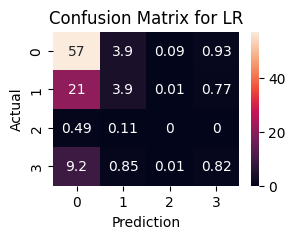

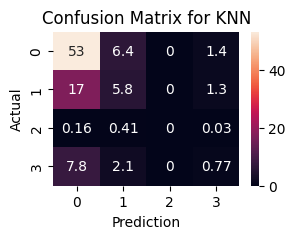

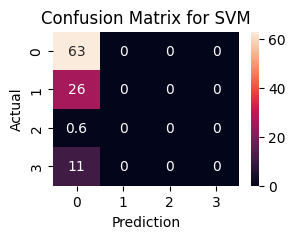

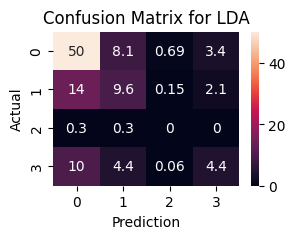

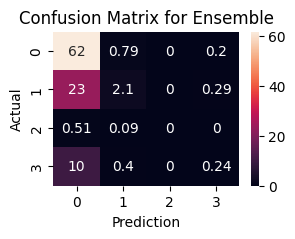

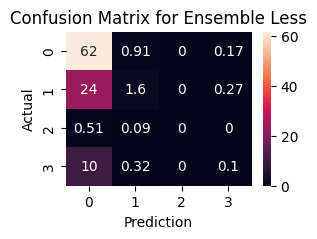

In [24]:
print_model_cfms(cfms)

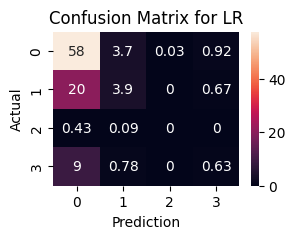

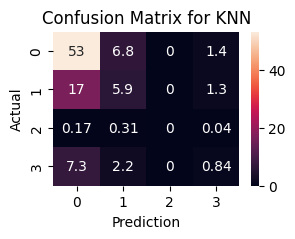

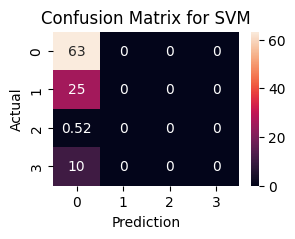

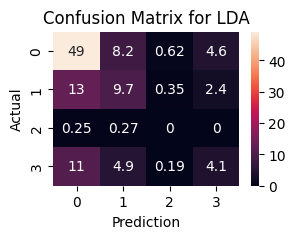

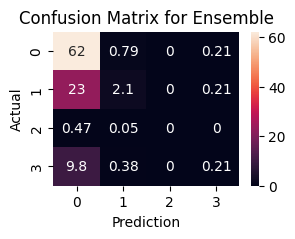

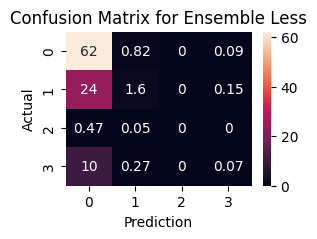

In [25]:
print_model_cfms(cfms_train)

Extract descriptive statistics from the accuracies.

In [26]:
stats = get_statistics(accs)
results = pd.DataFrame(stats, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass', 'KNN_multiclass', 
                                'SVM_multiclass', 'LDA_multiclass', 
                                'Ensemble_multiclass', 'Ensemble2_multiclass'])

results

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass
Mean,0.558929,0.543571,0.561696,0.580179,0.575089,0.567232
STD,0.038320,0.042414,0.035425,0.039021,0.036685,0.035947
Max,0.669643,0.642857,0.678571,0.687500,0.678571,0.678571
Min,0.464286,0.455357,0.464286,0.455357,0.473214,0.473214


In [27]:
stats_train = get_statistics(accs_train)
results_train = pd.DataFrame(stats_train, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_train', 'KNN_multiclass_train', 
                                'SVM_multiclass_train', 'LDA_multiclass_train', 
                                'Ensemble_multiclass_train', 'Ensemble2_multiclass_train'])

results_train

,LR_multiclass_train,KNN_multiclass_train,SVM_multiclass_train,LDA_multiclass_train,Ensemble_multiclass_train,Ensemble2_multiclass_train
Mean,0.562232,0.544821,0.564464,0.567321,0.577143,0.571071
STD,0.041409,0.043411,0.043897,0.044471,0.045255,0.043721
Max,0.660714,0.651786,0.669643,0.705357,0.687500,0.678571
Min,0.464286,0.455357,0.464286,0.482143,0.482143,0.482143


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [28]:
perform_cross_validation(X, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the num

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.553939393939394, 0.05062248972212617), 'KNN': (0.553939393939394, 0.043611220777411794), 'SVM': (0.5672727272727273, 0.00863857848615161), 'LDA': (0.5831818181818181, 0.0636860676501022), 'Ensemble': (0.5739393939393939, 0.022913045460618717), 'Ensemble Less': (0.5762626262626263, 0.019906935807797996)}


C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
perform_cross_validation(X_train, y_train)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the num

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.5673737373737374, 0.06144503476038091), 'KNN': (0.553939393939394, 0.043611220777411794), 'SVM': (0.5672727272727273, 0.00863857848615161), 'LDA': (0.5583838383838384, 0.09529653963433798), 'Ensemble': (0.5761616161616161, 0.022084975624895063), 'Ensemble Less': (0.5762626262626263, 0.02648892401745472)}


C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Method Conclusion

LDA was the most accurate method in the train/test split.

## Normalized Dataframe

This model will use a normalized version of the dataframe. 
This method will adjust the features to be normally distributed.

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [30]:
df_norm = df.copy()
df_train_norm = df_train.copy()

X_norm = df_norm.drop('DX', axis=1)

X_train_norm = df_train_norm.drop('DX', axis=1)

### Normalize columns

Normalize the features and update the feature dataframe to use these changes.

In [31]:
X_norm = normalize_features(X_norm)
X_train_norm = normalize_features(X_train_norm)

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [32]:
accs_norm, cfms_norm = get_accuracies(X_norm, y)

accs_train_norm, cfms_train_norm = get_accuracies(X_train_norm, y_train)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

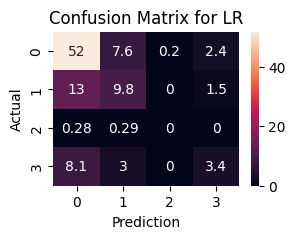

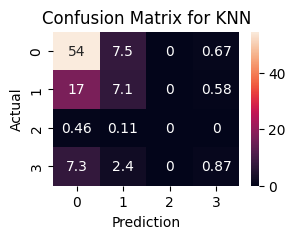

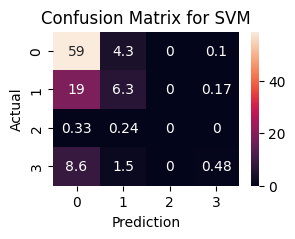

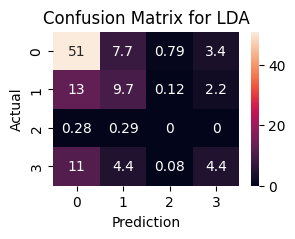

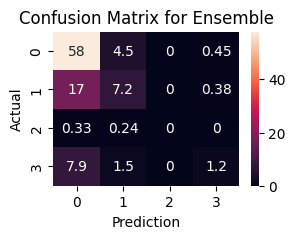

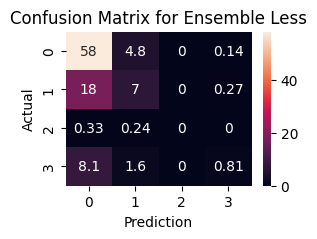

In [33]:
print_model_cfms(cfms_norm)

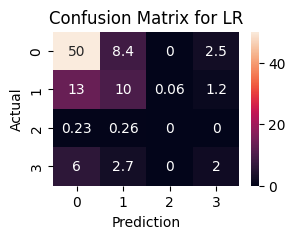

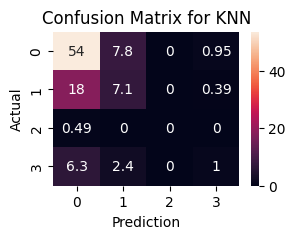

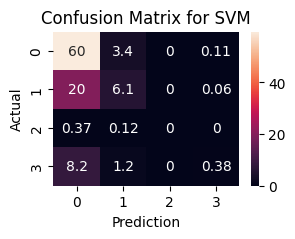

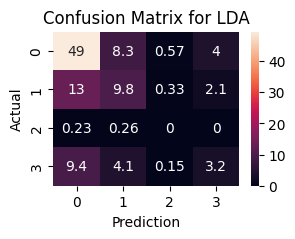

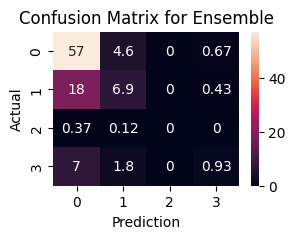

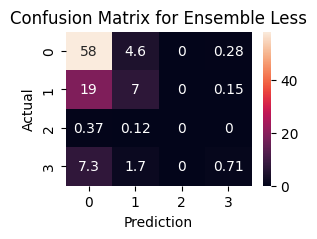

In [34]:
print_model_cfms(cfms_train_norm)

Extract descriptive statistics from the accuracies.

In [35]:
stats_norm = get_statistics(accs_norm)
results_norm = pd.DataFrame(stats_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_norm', 'KNN_multiclass_norm', 
                                'SVM_multiclass_norm', 'LDA_multiclass_norm',
                                'Ensemble_multiclass_norm', 'Ensemble2_multiclass_norm'])

results_norm

,LR_multiclass_norm,KNN_multiclass_norm,SVM_multiclass_norm,LDA_multiclass_norm,Ensemble_multiclass_norm,Ensemble2_multiclass_norm
Mean,0.595536,0.568125,0.589196,0.587321,0.602321,0.597679
STD,0.040317,0.037662,0.036542,0.041680,0.036496,0.037004
Max,0.705357,0.651786,0.687500,0.705357,0.705357,0.696429
Min,0.500000,0.473214,0.508929,0.491071,0.526786,0.508929


In [36]:
stats_train_norm = get_statistics(accs_train_norm)
results_train_norm = pd.DataFrame(stats_train_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_multiclass_train_norm', 'KNN_train_multiclass_norm', 
                                'SVM_multiclass_train_norm', 'LDA_train_multiclass_norm',
                                'Ensemble_multiclass_train_norm', 'Ensemble2_train_multiclass_norm'])

results_train_norm

,LR_multiclass_train_norm,KNN_train_multiclass_norm,SVM_multiclass_train_norm,LDA_train_multiclass_norm,Ensemble_multiclass_train_norm,Ensemble2_train_multiclass_norm
Mean,0.571161,0.562589,0.594375,0.565268,0.592143,0.595179
STD,0.043512,0.039920,0.041903,0.041739,0.043170,0.040725
Max,0.696429,0.669643,0.687500,0.678571,0.687500,0.678571
Min,0.473214,0.455357,0.491071,0.446429,0.500000,0.508929


Extract descriptive statistics from the accuracies.

#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [37]:
perform_cross_validation(X_norm, y)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.5877272727272728, 0.07270589262056332), 'KNN': (0.5718181818181818, 0.04794405899141401), 'SVM': (0.5919696969696969, 0.047493253431600296), 'LDA': (0.5831818181818181, 0.0636860676501022), 'Ensemble': (0.6056565656565657, 0.046986420396355956), 'Ensemble Less': (0.601010101010101, 0.053789182893091994)}


In [38]:
perform_cross_validation(X_train_norm, y_train)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_sp

Model		CV Mean		CV std
{'LR': (0.5585858585858586, 0.07971706676489428), 'KNN': (0.5562121212121213, 0.05808873463697874), 'SVM': (0.5828282828282828, 0.0533372549828466), 'LDA': (0.5583838383838384, 0.09529653963433798), 'Ensemble': (0.592020202020202, 0.04573136806057041), 'Ensemble Less': (0.591919191919192, 0.04789412872758873)}


### Method Conclusion

Ensemble of all standard classification models had the best accuracy.

This model performed better than the previous test.

## Classification Conclusion

The most accurate method for this classification method was Ensemble on the normalized dataframe.

--------------------------------------------------------------------------------------------------------------------------------

# Binary Classificaiton

This section investigates how models perform when predicting whether a patient has ADHD or not. 

This is accomplished by converting the diagnosis to a binary value based on if their diagnosis is a control or has some type of ADHD. 
For this feature, 'True' signifies the subject has ADHD and 'False' signifies the subject is a control and does not have ADHD.

Theoretically, this model should perform better than the multi-class classification since it is simpler.

## Base Binary Dataframe

The binary dataframe is exactly the same as the multiclass dataframe except the diagnosis is binary. 
Any value for 'DX' greater than 0 for this column indicates that the subject has ADHD.

In [39]:
df_binary = df.copy()
df_binary_train = df_train.copy()

df_binary['DX'].loc[df_binary['DX'] > 0] = 1
df_binary_train['DX'].loc[df_binary_train['DX'] > 0] = 1

## Binary Current Dataframe

This model will use the current dataframe with the only modification being to the diagnosis column. 
Any value for 'DX' greater than 0 indicates that the patient has ADHD.

This will act as a baseline to compare the binary models with other changes to.

### Separate data

Split the data into features and target.

In [40]:
X_binary = df_binary.drop('DX', axis=1)
y_binary = df_binary['DX']

X_binary_train = df_binary_train.drop('DX', axis=1)
y_binary_train = df_binary_train['DX']

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [41]:
accs_binary, cfm_binary = get_accuracies(X_binary, y_binary)

accs_binary_train, cfm_binary_train = get_accuracies(X_binary_train, y_binary_train)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

#### View Confusion Matrices

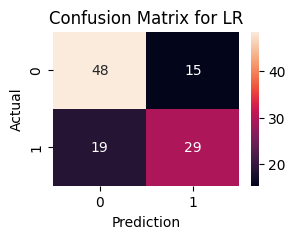

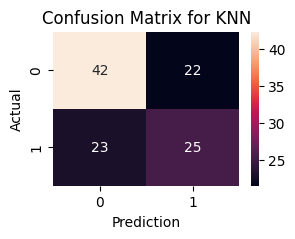

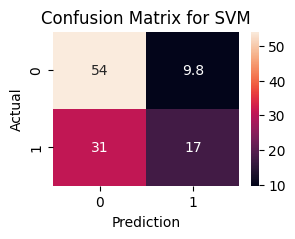

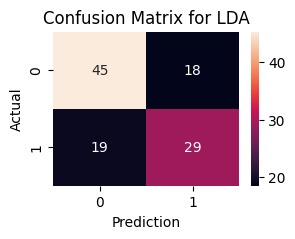

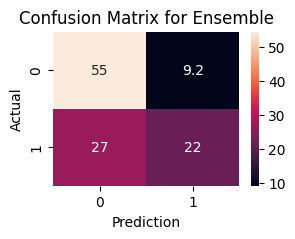

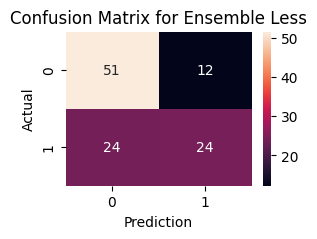

In [42]:
print_model_cfms(cfm_binary)

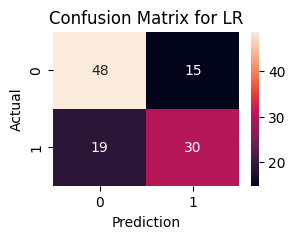

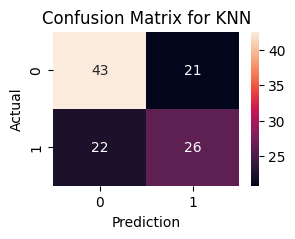

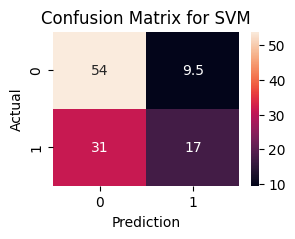

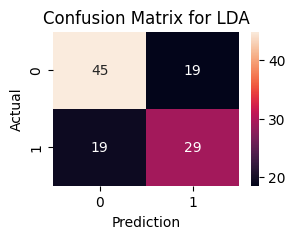

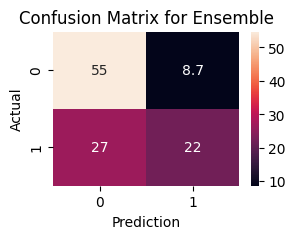

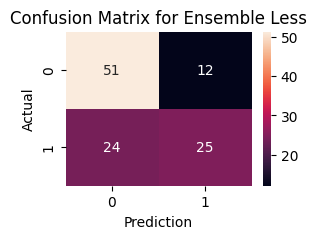

In [43]:
print_model_cfms(cfm_binary_train)

Extract descriptive statistics from the accuracies.

In [44]:
stats_binary = get_statistics(accs_binary)
results_binary = pd.DataFrame(stats_binary, 
                              index=['Mean', 'STD', 'Max', 'Min'], 
                              columns=['LR_binary', 'KNN_binary', 
                                       'SVM_binary', 'LDA_binary', 
                                       'Ensemble_binary', 'Ensemble2_binary'])

results_binary

,LR_binary,KNN_binary,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary
Mean,0.695268,0.603750,0.638036,0.664643,0.680089,0.675804
STD,0.033850,0.041875,0.051001,0.037229,0.040308,0.039320
Max,0.785714,0.696429,0.732143,0.785714,0.767857,0.758929
Min,0.598214,0.517857,0.446429,0.580357,0.580357,0.580357


In [45]:
stats_binary_train = get_statistics(accs_binary_train)
results_binary_train = pd.DataFrame(stats_binary_train, 
                              index=['Mean', 'STD', 'Max', 'Min'], 
                              columns=['LR_binary_train', 'KNN_binary_train', 
                                       'SVM_binary_train', 'LDA_binary_train', 
                                       'Ensemble_binary_train', 'Ensemble2_binary_train'])

results_binary_train

,LR_binary_train,KNN_binary_train,SVM_binary_train,LDA_binary_train,Ensemble_binary_train,Ensemble2_binary_train
Mean,0.699464,0.613839,0.636250,0.660536,0.685268,0.678304
STD,0.039209,0.039556,0.052816,0.043795,0.041867,0.038371
Max,0.794643,0.705357,0.741071,0.741071,0.776786,0.767857
Min,0.598214,0.491071,0.473214,0.517857,0.571429,0.598214


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [46]:
perform_cross_validation(X_binary, y_binary)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.6837878787878788, 0.08706621013018791), 'KNN': (0.5873232323232324, 0.08298901932692059), 'SVM': (0.6392929292929294, 0.10207989052995248), 'LDA': (0.6501010101010101, 0.09230847748064318), 'Ensemble': (0.6771717171717172, 0.07548090894755728), 'Ensemble Less': (0.6570707070707071, 0.11098293801001008)}


In [47]:
perform_cross_validation(X_binary_train, y_binary_train)

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Model		CV Mean		CV std
{'LR': (0.677070707070707, 0.0815083921946903), 'KNN': (0.5873232323232324, 0.08298901932692059), 'SVM': (0.6392929292929294, 0.10207989052995248), 'LDA': (0.6206565656565657, 0.09911156458489528), 'Ensemble': (0.6703030303030302, 0.06990081447960203), 'Ensemble Less': (0.6570707070707071, 0.10719499171296205)}


C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Method Conclusion

Logistic Regression is the most accurate model for train/test split.

This modle performed better than the previous tests.

## Normalized Binary Dataframe

This model will use a normalized version of the dataframe. 
This method will adjust the features to be normally distributed.

This should reduce some of the bias that results from the different scales in the dataframe's features

### Separate data

Make a copy of the original dataframe to ensure that it is preserved. 
Split the data into features and target.

In [48]:
df_binary_norm = df_binary.copy()
df_binary_train_norm = df_binary_train.copy()

X_binary_norm = df_binary_norm.drop('DX', axis=1)
X_binary_train_norm = df_binary_train_norm.drop('DX', axis=1)

### Normalize columns

Normalize the features and update the feature dataframe to use these changes.

In [49]:
X_binary_norm = normalize_features(X_binary_norm)
X_binary_train_norm = normalize_features(X_binary_train_norm)

### Evaluate Accuracy

Determine the accuracy of using this dataframe. 

#### 100-iteration Train/Test Split

Do 100-iterations of train/test splits using this dataframe. 
Generate 100 accuracies for the four models.

In [50]:
accs_binary_norm, cfm_binary_norm = get_accuracies(X_binary_norm, y_binary)

accs_binary_train_norm, cfm_binary_train_norm = get_accuracies(X_binary_train_norm, y_binary)

#### View Confusion Matrices

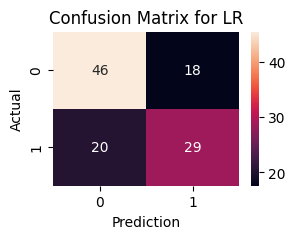

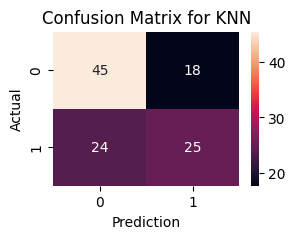

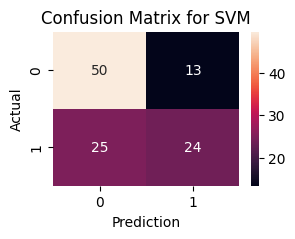

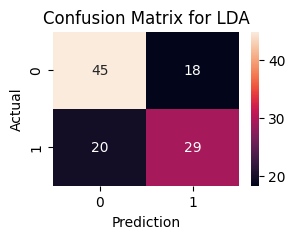

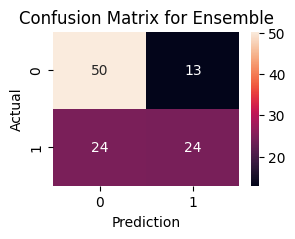

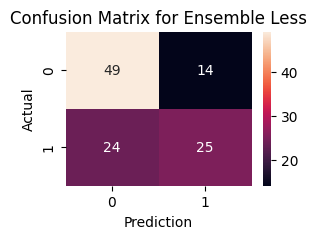

In [51]:
print_model_cfms(cfm_binary_norm)

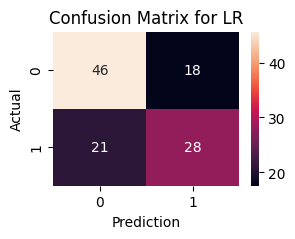

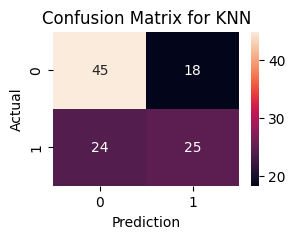

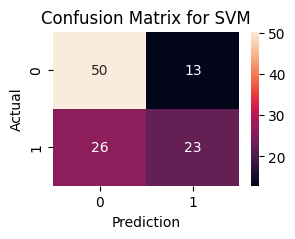

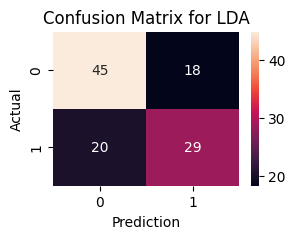

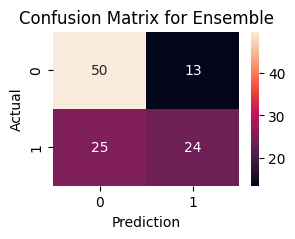

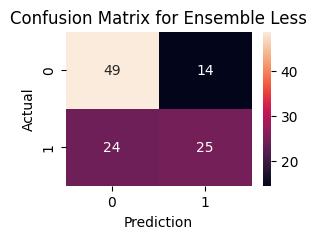

In [52]:
print_model_cfms(cfm_binary_train_norm)

Extract descriptive statistics from the accuracies.

In [53]:
stats_binary_norm = get_statistics(accs_binary_norm)
results_binary_norm = pd.DataFrame(stats_binary_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_binary_norm', 'KNN_binary_norm', 
                                'SVM_binary_norm', 'LDA_binary_norm', 
                                'Ensemble_binary_norm', 'Ensemble2_binary_norm'])

results_binary_norm

,LR_binary_norm,KNN_binary_norm,SVM_binary_norm,LDA_binary_norm,Ensemble_binary_norm,Ensemble2_binary_norm
Mean,0.662232,0.628929,0.656518,0.661250,0.665893,0.662768
STD,0.037309,0.042471,0.037848,0.037347,0.039893,0.037220
Max,0.758929,0.758929,0.732143,0.758929,0.758929,0.750000
Min,0.562500,0.535714,0.562500,0.580357,0.580357,0.589286


In [54]:
stats_binary_train_norm = get_statistics(accs_binary_train_norm)
results_binary_train_norm = pd.DataFrame(stats_binary_train_norm, 
                       index=['Mean', 'STD', 'Max', 'Min'], 
                       columns=['LR_binary_train_norm', 'KNN_binary_train_norm', 
                                'SVM_binary_train_norm', 'LDA_binary_train_norm', 
                                'Ensemble_binary_train_norm', 'Ensemble2_binary_train_norm'])

results_binary_train_norm

,LR_binary_train_norm,KNN_binary_train_norm,SVM_binary_train_norm,LDA_binary_train_norm,Ensemble_binary_train_norm,Ensemble2_binary_train_norm
Mean,0.656250,0.620714,0.650357,0.656607,0.655179,0.655179
STD,0.037701,0.041294,0.037388,0.037721,0.037196,0.036417
Max,0.741071,0.705357,0.723214,0.741071,0.741071,0.732143
Min,0.580357,0.508929,0.571429,0.571429,0.580357,0.580357


#### Cross-validation

Perform cross validation on this dataset with the four models from before. This is done to compare the results to the train-test split method.

In [55]:
perform_cross_validation(X_binary_norm, y_binary)

Model		CV Mean		CV std
{'LR': (0.6432323232323233, 0.09420030022019754), 'KNN': (0.6391414141414141, 0.08301569398868887), 'SVM': (0.6520202020202019, 0.09715733109241695), 'LDA': (0.6501010101010101, 0.09230847748064318), 'Ensemble': (0.6497979797979798, 0.07847620300003251), 'Ensemble Less': (0.6543939393939394, 0.07539206437739042)}


In [56]:
perform_cross_validation(X_binary_train_norm, y_binary_train)

Model		CV Mean		CV std
{'LR': (0.6206565656565657, 0.09305641557652554), 'KNN': (0.6191414141414142, 0.07471964059976484), 'SVM': (0.6340404040404041, 0.09833975325730217), 'LDA': (0.6206565656565657, 0.09911156458489528), 'Ensemble': (0.6227777777777779, 0.09498909823120369), 'Ensemble Less': (0.6228787878787878, 0.09779871061094596)}


### Method Conclusion

LDA is the most accurate model for both train/test split.

This did not perform better than the previous test.

## Classification Conclusion

The binary classification yielded more accurate predictions on average. 
The most accurate model is Ensemble for the binary classification. 
This model is the best in the notebook.

--------------------------------------------------------------------------------------------------------------------------------

# Complete Results

Combine the accuracy from the multiclass and binary tests. 

Concatenate the two results to a single dataframe to export.

### Combine accuracy from classifications

Combine all types of results into a single dataframe with all descriptive statistics.

Results using condensed dataframes

In [57]:
results_complete = pd.concat([results, results_norm, results_binary, results_binary_norm], axis=1)
results_complete

,LR_multiclass,KNN_multiclass,SVM_multiclass,LDA_multiclass,Ensemble_multiclass,Ensemble2_multiclass,LR_multiclass_norm,KNN_multiclass_norm,SVM_multiclass_norm,LDA_multiclass_norm,...,SVM_binary,LDA_binary,Ensemble_binary,Ensemble2_binary,LR_binary_norm,KNN_binary_norm,SVM_binary_norm,LDA_binary_norm,Ensemble_binary_norm,Ensemble2_binary_norm
Mean,0.558929,0.543571,0.561696,0.580179,0.575089,0.567232,0.595536,0.568125,0.589196,0.587321,...,0.638036,0.664643,0.680089,0.675804,0.662232,0.628929,0.656518,0.661250,0.665893,0.662768
STD,0.038320,0.042414,0.035425,0.039021,0.036685,0.035947,0.040317,0.037662,0.036542,0.041680,...,0.051001,0.037229,0.040308,0.039320,0.037309,0.042471,0.037848,0.037347,0.039893,0.037220
Max,0.669643,0.642857,0.678571,0.687500,0.678571,0.678571,0.705357,0.651786,0.687500,0.705357,...,0.732143,0.785714,0.767857,0.758929,0.758929,0.758929,0.732143,0.758929,0.758929,0.750000
Min,0.464286,0.455357,0.464286,0.455357,0.473214,0.473214,0.500000,0.473214,0.508929,0.491071,...,0.446429,0.580357,0.580357,0.580357,0.562500,0.535714,0.562500,0.580357,0.580357,0.589286


Results using training condensed dataframes

In [58]:
results_complete_train = pd.concat([results_train, results_train_norm, 
                                    results_binary_train, results_binary_train_norm], axis=1)
results_complete_train

,LR_multiclass_train,KNN_multiclass_train,SVM_multiclass_train,LDA_multiclass_train,Ensemble_multiclass_train,Ensemble2_multiclass_train,LR_multiclass_train_norm,KNN_train_multiclass_norm,SVM_multiclass_train_norm,LDA_train_multiclass_norm,...,SVM_binary_train,LDA_binary_train,Ensemble_binary_train,Ensemble2_binary_train,LR_binary_train_norm,KNN_binary_train_norm,SVM_binary_train_norm,LDA_binary_train_norm,Ensemble_binary_train_norm,Ensemble2_binary_train_norm
Mean,0.562232,0.544821,0.564464,0.567321,0.577143,0.571071,0.571161,0.562589,0.594375,0.565268,...,0.636250,0.660536,0.685268,0.678304,0.656250,0.620714,0.650357,0.656607,0.655179,0.655179
STD,0.041409,0.043411,0.043897,0.044471,0.045255,0.043721,0.043512,0.039920,0.041903,0.041739,...,0.052816,0.043795,0.041867,0.038371,0.037701,0.041294,0.037388,0.037721,0.037196,0.036417
Max,0.660714,0.651786,0.669643,0.705357,0.687500,0.678571,0.696429,0.669643,0.687500,0.678571,...,0.741071,0.741071,0.776786,0.767857,0.741071,0.705357,0.723214,0.741071,0.741071,0.732143
Min,0.464286,0.455357,0.464286,0.482143,0.482143,0.482143,0.473214,0.455357,0.491071,0.446429,...,0.473214,0.517857,0.571429,0.598214,0.580357,0.508929,0.571429,0.571429,0.580357,0.580357


Export results from non-training dataframes as .csv files

In [59]:
results_complete.to_csv(base_folder_filepath + '\\Results\\2023.7.25-Phenotypic_and_Region_Condensed-Results.csv')

### Evaluate Controlled train/test split

Use the same random state as was used in feature selection to determine the accuracy of the models.

In [60]:
training_acc_binary = get_training_accuracies(X_binary_train, y_binary_train)
training_acc_binary

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

LR               0.714286
KNN              0.616071
SVM              0.678571
LDA              0.687500
Ensemble         0.687500
Ensemble Less    0.696429
dtype: float64

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

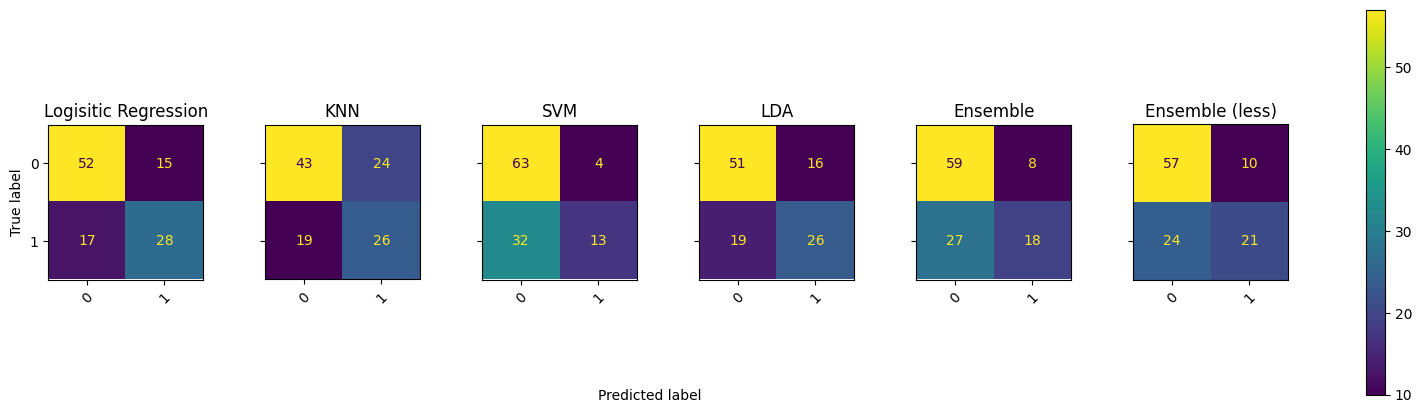

In [61]:
print_training_cfm(X_binary_train, y_binary_train)

In [62]:
training_acc_binary_norm = get_training_accuracies(X_binary_train_norm, y_binary_train)
training_acc_binary_norm

LR               0.687500
KNN              0.660714
SVM              0.705357
LDA              0.687500
Ensemble         0.705357
Ensemble Less    0.714286
dtype: float64

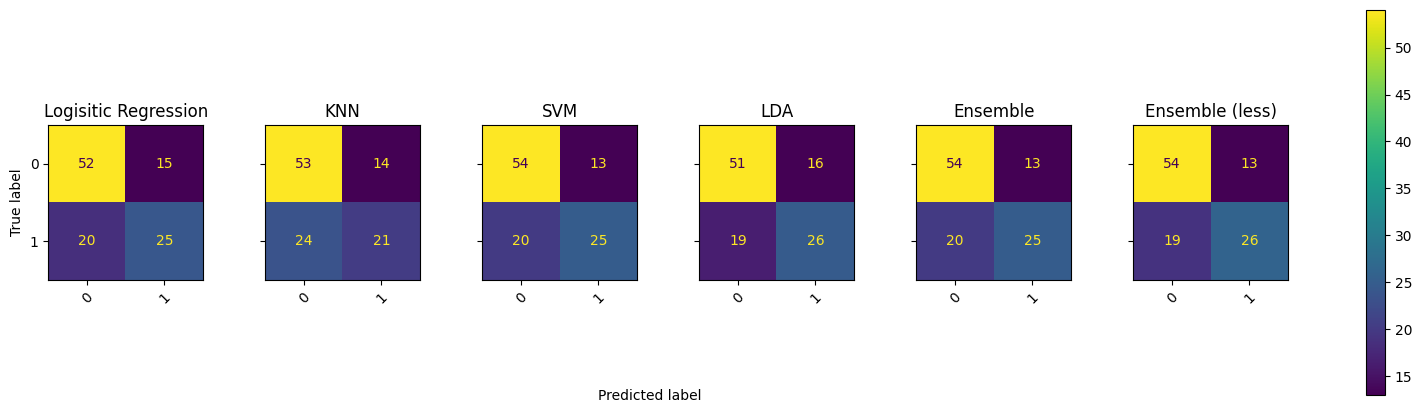

In [63]:
print_training_cfm(X_binary_train_norm, y_binary_train)

In [64]:
training_acc = get_training_accuracies(X_train, y_train)
training_acc

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

LR               0.616071
KNN              0.580357
SVM              0.598214
LDA              0.633929
Ensemble         0.607143
Ensemble Less    0.625000
dtype: float64

C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\taylo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

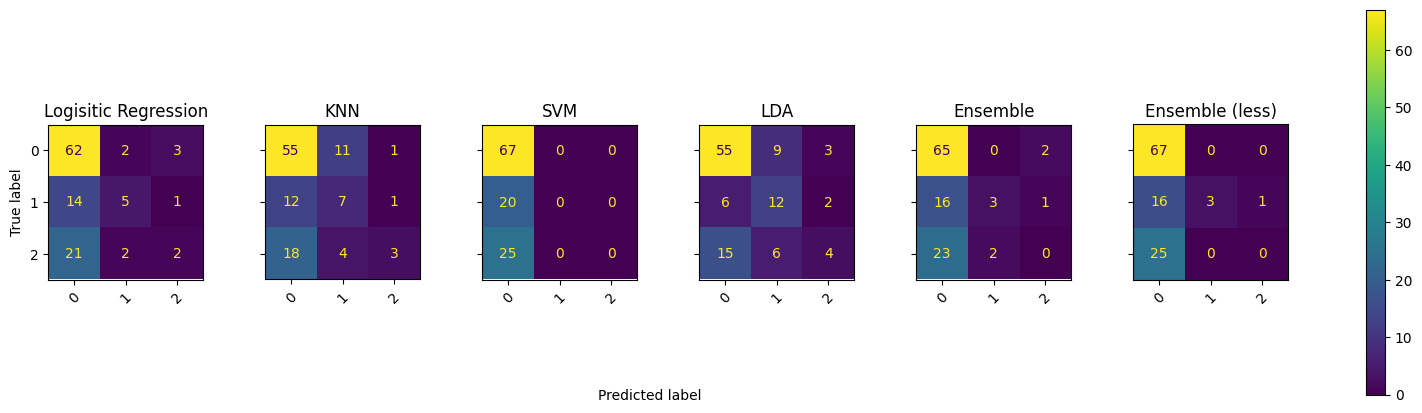

In [65]:
print_training_cfm(X_train, y_train)

In [66]:
training_acc_norm = get_training_accuracies(X_train_norm, y_train)
training_acc_norm

LR               0.633929
KNN              0.616071
SVM              0.633929
LDA              0.633929
Ensemble         0.651786
Ensemble Less    0.642857
dtype: float64

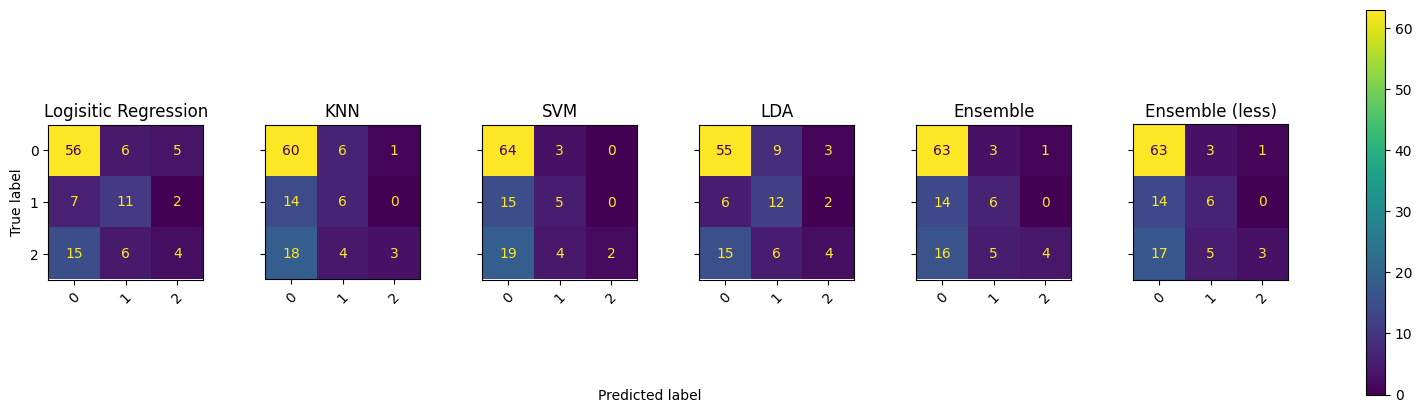

In [67]:
print_training_cfm(X_train_norm, y_train)

Combine results into dataframes

In [68]:
model_types = ['Binary', 'Binary Normalized', 'Multiclass', 'Multiclass Normalized']
training_results = pd.concat([training_acc_binary, training_acc_binary_norm, 
                             training_acc, training_acc_norm], axis=1)

training_results.columns = model_types

In [69]:
training_results

,Binary,Binary Normalized,Multiclass,Multiclass Normalized
LR,0.714286,0.687500,0.616071,0.633929
KNN,0.616071,0.660714,0.580357,0.616071
SVM,0.678571,0.705357,0.598214,0.633929
LDA,0.687500,0.687500,0.633929,0.633929
Ensemble,0.687500,0.705357,0.607143,0.651786
Ensemble Less,0.696429,0.714286,0.625000,0.642857


Export results as .csv files

In [70]:
training_results.to_csv(base_folder_filepath + '\\Results\\2023.7.24-Phenotypic_and_Region_Condensed_Train-Results.csv')